Download the Flowers dataset: http://download.tensorflow.org/example_images/flower_photos.tgz. This dataset contains 3,670 images of 5 diﬀerent ﬂower species. Uncompress the dataset in a target folder.

Tasks:

1. Train a convolutional neural network with a softmax layer in order to predict the type of ﬂower.

2. Experiment with diﬀerent numbers and sizes of convolutional layers to reduce the prediction error.

In [2]:
# !tar -xf flower_photos.tgz
dataset_in = 'flower_photos'

In [35]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [222]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import splitfolders

# Split the dataset into train, validation and test sets
input_folder = 'flower_photos/'
output_folder = 'splitted_data/'
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .15, .10)) # Train, Val, Test

# Define ImageDataGenerator for training and validation
datagen_train_val = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

# Load train and validation data
train_generator = datagen_train_val.flow_from_directory(
    output_folder + 'train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

validation_generator = datagen_train_val.flow_from_directory(
    output_folder + 'val',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

# Define ImageDataGenerator for testing (without data augmentation)
datagen_test = ImageDataGenerator(rescale=1./255)

# Load test data
test_generator = datagen_test.flow_from_directory(
    output_folder + 'test',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

  

Copying files: 3670 files [00:01, 2272.30 files/s]


Found 2750 images belonging to 5 classes.
Found 547 images belonging to 5 classes.
Found 373 images belonging to 5 classes.


Epoch 1/80
85/85 [==============================] - 22s 257ms/step - loss: 1.5783 - accuracy: 0.3109 - val_loss: 1.4395 - val_accuracy: 0.4246
Epoch 2/80
85/85 [==============================] - 22s 257ms/step - loss: 1.4398 - accuracy: 0.3926 - val_loss: 1.4366 - val_accuracy: 0.4485
Epoch 3/80
85/85 [==============================] - 20s 240ms/step - loss: 1.3911 - accuracy: 0.4345 - val_loss: 1.3051 - val_accuracy: 0.4614
Epoch 4/80
85/85 [==============================] - 24s 277ms/step - loss: 1.3483 - accuracy: 0.4305 - val_loss: 1.2878 - val_accuracy: 0.4540
Epoch 5/80
85/85 [==============================] - 24s 278ms/step - loss: 1.3247 - accuracy: 0.4345 - val_loss: 1.2799 - val_accuracy: 0.4761
Epoch 6/80
85/85 [==============================] - 25s 288ms/step - loss: 1.2935 - accuracy: 0.4765 - val_loss: 1.2358 - val_accuracy: 0.4430
Epoch 7/80
85/85 [==============================] - 27s 320ms/step - loss: 1.2433 - accuracy: 0.4864 - val_loss: 1.1800 - val_accuracy: 0.4890

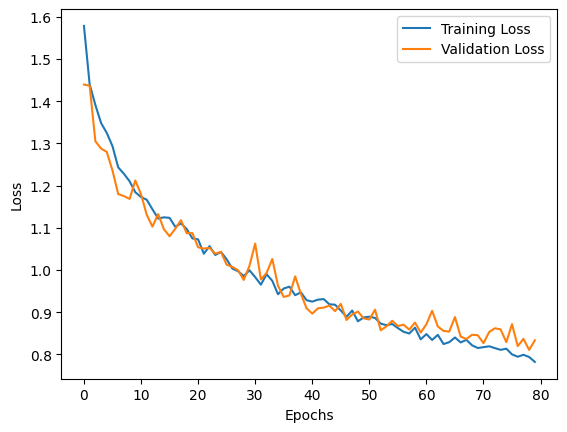

In [230]:
from tensorflow.keras.layers import  Conv2D, BatchNormalization, Flatten, MaxPooling2D, Dense,Dropout,LeakyReLU,Activation,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

from matplotlib import pyplot as plt


# Build the CNN model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = 3,padding = 'Same',activation ='relu', input_shape = (64,64,3)))
model.add(Conv2D(filters = 64, kernel_size = 3,padding = 'Same',activation ='relu'))
model.add(Conv2D(filters =96, kernel_size = 3,padding = 'same',activation ='relu'))
model.add(Conv2D(filters =10, kernel_size = 1,padding = 'valid',activation ='relu'))
model.add(GlobalAveragePooling2D())

model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(5, activation = "softmax", kernel_regularizer='l2'))


# 1) Adam is generally a good optimizer to use for many cases. The adam optimizer adjusts the learning rate throughout training.
# 2) We will use ‘categorical_crossentropy’ for our loss function. 
# This is the most common choice for classification. A lower score indicates that the model is performing better.
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=80,
    verbose=1
)

# Plotting the training progress (loss)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [82]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        2432      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 16, 16, 64)       

12/12 [==============================] - 1s 77ms/step - loss: 0.8021 - accuracy: 0.7051


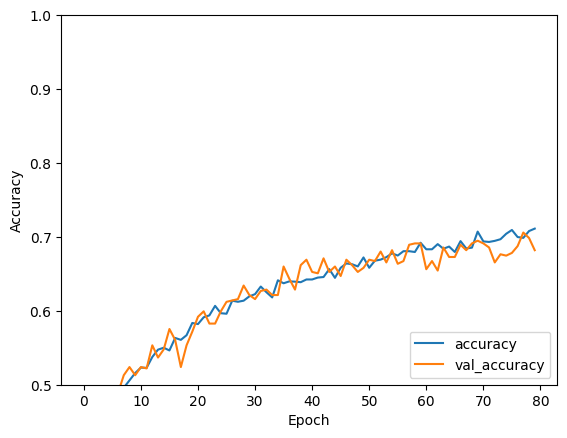

In [231]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_accuracy = model.evaluate(test_generator)

12/12 [==============================] - 1s 64ms/step - loss: 0.8021 - accuracy: 0.7051


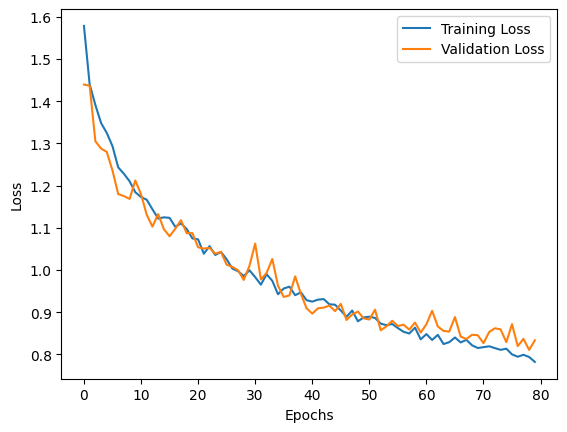

In [233]:
test_loss, test_accuracy = model.evaluate(test_generator)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()